enforce **validation rules**, **security measures**, and **user-friendly messages** to ensure clean and correct data entry. Below are the **conditions** you should apply for each input field:

---

### **Input Field Conditions & Validation**
| Feature | Input Type | Conditions & Validation | Error Message |
|---------|------------|-------------------------|---------------|
| `sqft_living` | Number (integer) | - Required field<br>- Min: 200 (smallest livable area)<br>- Max: 10,000 (upper limit for large houses) | "Living area must be between 200 and 10,000 sqft." |
| `no_of_bedrooms` | Number (integer) | - Required field<br>- Min: 1<br>- Max: 25 | "Number of bedrooms must be between 1 and 25." |
| `no_of_bathrooms` | Number (float) | - Required field<br>- Min: 1.0<br>- Max: 15.0 (Allows half bathrooms, e.g., 1.5) | "Number of bathrooms must be between 1 and 15." |
| `sqft_lot` | Number (integer) | - Required field<br>- Min: 500 (Smallest valid lot size)<br>- Max: 50,000 | "Lot size must be between 500 and 50,000 sqft." |
| `no_of_floors` | Number (integer) | - Required field<br>- Min: 0<br>- Max: 10 | "Floors must be between 1 and 4." |
| `house_age` | Number (integer) | - Required field<br>- Min: 0 (New house)<br>- Max: 150 (Oldest reasonable house) | "House age must be between 0 and 150 years." |
| `zipcode` | Number (integer) | - Required field<br>- Range: **98001 - 99001**<br>- Display a tooltip/tag: `"Enter a valid ZIP code between 98001 and 99001"` | "Invalid ZIP code. Must be between 98001 and 99001." |

---

### **Security Measures**
1. **Sanitize Input**  
   - Ensure only **numbers** are entered where required (e.g., no letters in ZIP codes, no special characters in numerical fields).
   - Use **HTML5 input types** (`type="number"`, `step="0.5"` for decimals).
   - Backend validation in Flask to prevent invalid input.

2. **Prevent SQL Injection & XSS Attacks**
   - Use **parameterized queries** when storing or retrieving data.
   - Encode special characters in form input (`<`, `>`, `'`, `"`).
   - Validate inputs both on **frontend (JS/HTML)** and **backend (Flask)**.

3. **Rate Limiting & Session Security**
   - Implement **rate limiting** (e.g., using Flask-Limiter) to prevent spam requests.
   - Use **CSRF protection** (`Flask-WTF` if using forms).
   - Hash and secure data in SQLite.

---

### **Error Handling & UX Enhancements**
- **Real-time validation** using JavaScript (e.g., show a red border & error text instantly when input is invalid).
- **User-Friendly Messages** with tooltips or small text under inputs.
- **Clear error messages** to guide the user on how to correct inputs.
- **Auto-formatting** for certain fields (e.g., auto-format ZIP codes).

---






[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18765
[LightGBM] [Info] Number of data points in the train set: 16141, number of used features: 579
[LightGBM] [Info] Start training from score 12.964625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

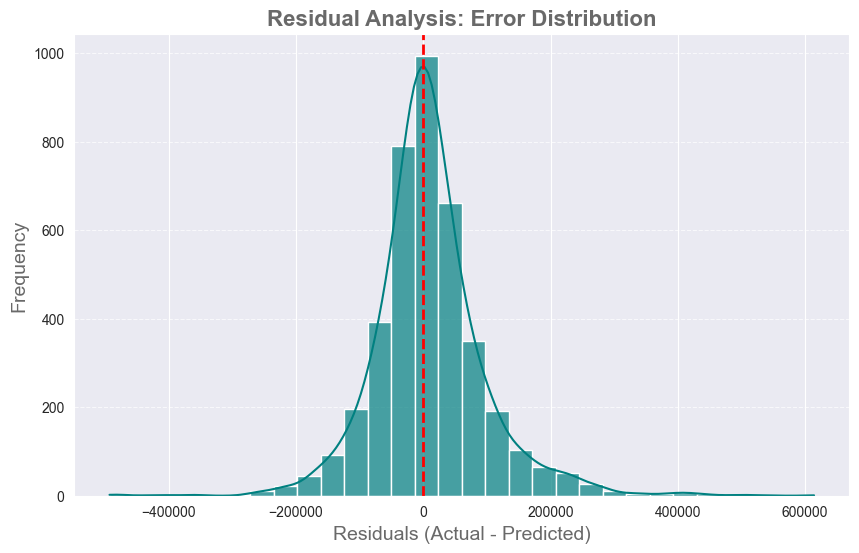

c:\Users\AMON\Desktop\C200\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


User Predicted Price: 524,004.70
Confidence Interval: 352,898.99 - 695,110.42
Mean Absolute Error: 60,946.09
R-squared: 0.7988



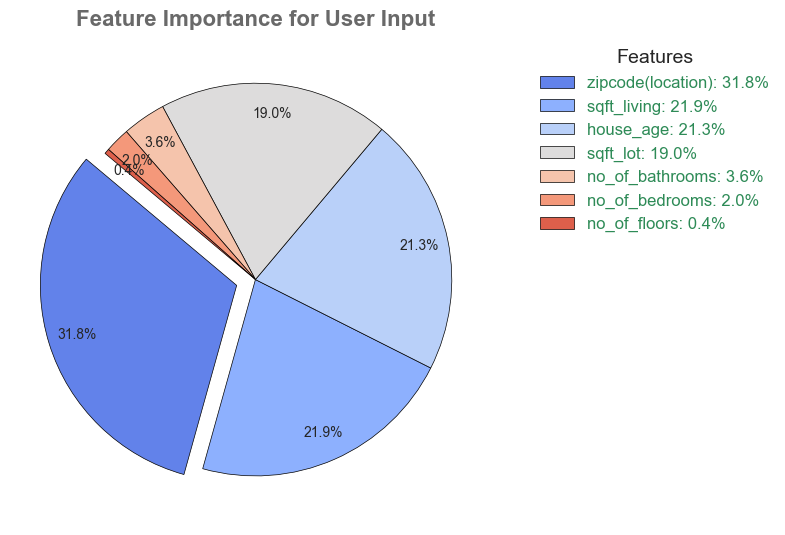

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

#  1. Load the dataset
data_path = r'C:\Users\AMON\Desktop\C200\data\processed\cleaned_dataset_iqr.csv'
df = pd.read_csv(data_path)

#  2. Preprocessing
features = ["sqft_living", "no_of_bedrooms", "no_of_bathrooms", "sqft_lot", "no_of_floors", "house_age", "zipcode"]
target = "price"

X = df[features]
y = df[target]

#  3. Log Transformation of Target Variable
y = np.log1p(y)

#  4. One-Hot Encoding for 'zipcode'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[['zipcode']])
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['zipcode']))
X = X.drop(columns=['zipcode'])
X = pd.concat([X, encoded_df], axis=1)

#  5. Polynomial Feature Creation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.columns))

#  6. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

#  7. Train LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42)
lgb_model.fit(X_train, y_train)

#  8. Make Predictions
y_pred = np.expm1(lgb_model.predict(X_test))     # Inverse log transformation to get predicted price in original scale
y_test = np.expm1(y_test)                         # Inverse log transformation for actual test values


#  9. Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#  10. Confidence Interval Calculation
std_dev = np.std(y_test - y_pred)
ci_min = y_pred - (1.96 * std_dev)
ci_max = y_pred + (1.96 * std_dev)

#  11. Residual Analysis (Modern, Styled)
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")  # Custom background style
sns.histplot(y_test - y_pred, bins=30, kde=True, color='teal', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Analysis: Error Distribution', fontsize=16, fontweight='bold', color='dimgray')
plt.xlabel('Residuals (Actual - Predicted)', fontsize=14, color='dimgray')
plt.ylabel('Frequency', fontsize=14, color='dimgray')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#  12. Simulated User Input
user_input = {"sqft_living": 2500, "no_of_bedrooms": 5, "no_of_bathrooms": 4, "sqft_lot": 3500, "no_of_floors": 1, "house_age": 10, "zipcode": "98001"}
user_input_df = pd.DataFrame([user_input])
user_encoded = encoder.transform(user_input_df[['zipcode']])
encoded_user_input = pd.DataFrame(user_encoded, columns=encoder.get_feature_names_out(['zipcode']))
user_input_df = user_input_df.drop(columns=['zipcode'])
user_input_df = pd.concat([user_input_df, encoded_user_input], axis=1)
user_input_poly = poly.transform(user_input_df)
user_pred = np.expm1(lgb_model.predict(user_input_poly))

#  13. Compute Confidence Interval for User Input
user_std_dev = np.std(y_test - y_pred)
user_ci_min = user_pred - (1.96 * user_std_dev)
user_ci_max = user_pred + (1.96 * user_std_dev)

#  14. Display Prediction Results
print(f"User Predicted Price: {user_pred[0]:,.2f}")
print(f"Confidence Interval: {user_ci_min[0]:,.2f} - {user_ci_max[0]:,.2f}")
print(f"Mean Absolute Error: {mae:,.2f}")
print(f"R-squared: {r2:.4f}\n")

#  15. Extract Feature Importances from the Model
feature_importances = pd.DataFrame({
    "Feature": X_poly.columns,
    "Importance": lgb_model.feature_importances_
})

#  16. Feature Importance Pie Chart for User's Input Features

#  Step 1: Identify zip code one-hot encoded feature columns dynamically.
zipcode_columns = [col for col in X.columns if col.startswith("zipcode_")]

#  Step 2: Filter feature importance for all relevant features, excluding zip codes.
features_without_zip = [col for col in X.columns if col not in zipcode_columns]
filtered_importance = feature_importances[feature_importances["Feature"].isin(features_without_zip)]

#  Step 3: Sum the importance of all zip code features (to allocate to 'zipcode(location)').
zipcode_importance = feature_importances[feature_importances["Feature"].isin(zipcode_columns)]["Importance"].sum()

#  Step 4: Add the 'zipcode(location)' entry with summed importance.
zipcode_row = pd.DataFrame({
    "Feature": ["zipcode(location)"],
    "Importance": [zipcode_importance]
})

#  Step 5: Concatenate the 'zipcode(location)' row with the filtered importance.
final_importance = pd.concat([filtered_importance, zipcode_row], ignore_index=True)

#  Step 6: Calculate the total importance and adjust percentages.
total_importance = final_importance["Importance"].sum()
final_importance["Percentage"] = (final_importance["Importance"] / total_importance) * 100

#  Step 7: Sort the final importance in descending order (highest to lowest).
final_importance_sorted = final_importance.sort_values(by="Importance", ascending=False)


#  Step 8: Create the pie chart with explode effect (2D)
def plot_pie_chart():
    plt.figure(figsize=(8, 8))

    # Define explode effect (only the highest feature is exploded)
    explode = [0.1] + [0] * (len(final_importance_sorted) - 1)  # Explode only the first slice

    pie_chart = plt.pie(
        final_importance_sorted["Percentage"],
        autopct='%1.1f%%',  # Display percentages inside slices
        colors=sns.color_palette("coolwarm", len(final_importance_sorted)),  # Color palette
        startangle=140,
        wedgeprops={'edgecolor': 'black', 'linewidth': 0.5},  # Add edges to the pie slices
        pctdistance=0.85,  # Move the percentages closer to the center to prevent overlap
        explode=explode,  # Apply explode effect
        shadow=False  # Ensure the chart remains 2D
    )

    #  Step 9: Add a legend with feature names and percentages.
    # Create legend labels with space and color for percentages
    legend_labels = [
        f"{feature}: {percentage:.1f}%"  # Format to show percentage after feature name
        for feature, percentage in zip(final_importance_sorted["Feature"], final_importance_sorted["Percentage"])
    ]

    #  Add the legend with percentages alongside feature names
    plt.legend(
        legend_labels,  # Use the new labels that include percentages
        title="Features",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),  # Adjust position of legend for more space
        title_fontsize='14',
        fontsize='12',
        frameon=False,
        markerscale=1.5
    )

    #  Step 10: Modify the colors of the percentages in the legend and adjust spacing.
    for i, label in enumerate(plt.gca().get_legend().get_texts()):
        if label.get_text().endswith('%'):
            label.set_color('seagreen')  # Color for percentages (lighter color)
        else:
            label.set_color('darkslategray')  # Color for features (darker color)

    #  Step 11: Add a title to the chart.
    plt.title(
        "Feature Importance for User Input",
        fontsize=16,
        fontweight='bold',
        color='dimgray',
        family='sans-serif'
    )

    #  Step 12: Show the pie chart with modern styling.
    plt.gca().set_facecolor('white')  # White background
    plt.tight_layout()  # Prevent overlap
    plt.show()

#  Call the pie chart function after user input
plot_pie_chart()

import joblib

 #Provide the correct path to the saved_model directory
model_save_path = r'C:\Users\AMON\Desktop\C200\model\saved_model\model.pkl'

 #Save the trained model using joblib
joblib.dump(lgb_model, model_save_path)

print(f"Model saved at {model_save_path}")




# LETS SEE
# PDD N PERMUTATION

In [1]:
import pandas as pd

# Load the dataset
data_path = r'C:\Users\AMON\Desktop\C200\data\processed\cleaned_dataset_iqr.csv'
df = pd.read_csv(data_path)

# Check if the 'zipcode' column exists in the dataset
if 'zipcode' in df.columns:
    # Calculate the minimum, maximum, and the difference
    min_zipcode = df['zipcode'].min()
    max_zipcode = df['zipcode'].max()
    diff_zipcode = max_zipcode - min_zipcode

    # Print the results
    print(f"Minimum Zipcode: {min_zipcode}")
    print(f"Maximum Zipcode: {max_zipcode}")
    print(f"Difference between Min and Max Zipcode: {diff_zipcode}")
else:
    print("The 'zipcode' column does not exist in the dataset.")


Minimum Zipcode: 98001
Maximum Zipcode: 98199
Difference between Min and Max Zipcode: 198
